# Using ```topicmod``` functions to easily apply topic modelling LDA and NMF techniques to text data stored in ```pandas.DataFrame``` 

In this example script, we show how ```nlpfunctions.topicmod``` functions can make it easy to apply Latent Derichlet Analysis (LDA) and Non-negative Matrix Factorization (NMF) models to text data and store the results in ```pandas.DataFrame``` so that they can be used in other analyses and explorations.

We will:
1. A
2. B
3. C
4. D

## Set ups and Imports

Import modules and our user-defined functions

In [1]:
import os
import re
import time
import string
import bigfloat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter
from nltk import word_tokenize
from random import shuffle

from sklearn import decomposition
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin

from nlpfunctions.utils import *
from nlpfunctions.basicnlp import *
from nlpfunctions.nlppipelineutils import *

from gensim import models, corpora


/Users/alessia/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


## Data

We will use the same labelled text data as in Example 2 and 3 from "From Group to Individual Labels using Deep Features', Kotzias et. al,. KDD 2015" (available here)

In [2]:
imdb = pd.read_excel('Data/imdb.xlsx', header=0)
yelp = pd.read_excel('Data/yelp_labelled.xlsx', header=0)

imdb['source'] = 'imdb'
yelp['source'] = 'yelp'

df = pd.concat([imdb, yelp])

df[df.duplicated('text')]
df = df.drop_duplicates('text')

df[pd.isnull(df['text'])]   #yep, 1 case
df = df[pd.notnull(df['text'])]   

In [3]:
print(df.head())
print(df.tail())

                                                text  score source
0  A very, very, very slow-moving, aimless movie ...      0   imdb
1  Not sure who was more lost - the flat characte...      0   imdb
2  Attempting artiness with black & white and cle...      0   imdb
3       Very little music or anything to speak of.        0   imdb
4  The best scene in the movie was when Gerardo i...      1   imdb
                                                  text  score source
994  I think food should have flavor and texture an...      0   yelp
995                           Appetite instantly gone.      0   yelp
996  Overall I was not impressed and would not go b...      0   yelp
997  The whole experience was underwhelming, and I ...      0   yelp
998  Then, as if I hadn't wasted enough of my life ...      0   yelp


### Word frequency

Let's take a look at the most frequent words

In [4]:
# Plot most frequent words

# https://www.kaggle.com/arthurtok/spooky-nlp-and-topic-modelling-tutorial
all_words = df['text'].str.split(expand=True).unstack().value_counts()
all_words = all_words.to_frame().reset_index().rename(columns = {'index' : 'word', 0 : 'count'})

# get 25 more frequent words
all_words[:25].plot.bar(x='word')
all_words[:25].T

#lots of "rubbish"...

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
word,the,and,a,I,is,of,was,to,The,this,...,with,are,movie,as,This,be,but,on,0,you
count,1012,779,618,534,473,468,461,441,354,287,...,152,133,126,117,115,113,113,113,112,111


### Clean text data for topic modelling


We will:
1. tokenise
2. lower case
3. remove stopwords
4. remove non-alphabetic tokens (i.e., punctuations and numbers)
5. lemmatise

In [5]:
preprocessing_pipe = combine_functions(sent_tokenise
                                       ,word_tokenise
                                       ,to_lower
                                       ,POS_tagging
                                       ,lemmatise
                                       ,fix_neg_auxiliary
                                       ,lambda x : remove_stopwords(x, extra_stopwords = [
                                           'x', "'s", "not", 'us', 'no', 'many', 'much', 'one', 'put', 've',
                                           'say', 'want', 'm', 'ever', 'every', 'really', 'well', 'little', 'd',
                                           'also', 'get', 'would', 'could', 'like', 'go', 'lot', 'make'])
                                       ,lambda s: [[re.sub(r'\d+','',x) for x in subs] for subs in s]
                                       ,flattenIrregularListOfLists
                                       ,remove_punctuation
                                       ,lambda x: list(filter(None, x))
                                      )   

In [6]:
df['text_lemmas'] = df['text'].apply(lambda x: preprocessing_pipe(x))

# check some texts
df[['text', 'text_lemmas']][:5]

,text,text_lemmas
0,"A very, very, very slow-moving, aimless movie ...","[slowmoving, aimless, movie, distressed, drift..."
1,Not sure who was more lost - the flat characte...,"[sure, lost, flat, character, audience, nearly..."
2,Attempting artiness with black & white and cle...,"[attempt, artiness, black, white, clever, came..."
3,Very little music or anything to speak of.,"[music, anything, speak]"
4,The best scene in the movie was when Gerardo i...,"[best, scene, movie, gerardo, try, find, song,..."


### Lemma frequency

In [67]:
# re-plot most frequent words

all_lemmas = df['text_lemmas'].apply(list2string).str.split(expand=True).unstack().value_counts()
all_lemmas = all_lemmas.to_frame().reset_index().rename(columns = {'index' : 'word', 0 : 'count'})

# get 25 more frequent lemmas
all_lemmas[:25].plot.bar(x='word')
all_lemmas[:25].T

# much better!

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
word,movie,film,good,food,bad,place,great,time,service,see,...,think,best,watch,never,way,give,look,thing,ve,pretty
count,200,173,169,124,121,117,111,100,84,72,...,53,53,51,43,41,38,38,37,35,33


## Topic modelling with Latent Dirichlet Analysis (LDA)

LDA is a generative statistical topic model used to find accurate sets of topics within a given document set. The model assumes that text documents are comprised of a mix of topics and each topic is comprised of a mix of words. From there, using probability distributions the model can determine which topics are in a given document and which words are in a given topic based on word prevalence across topics and topic prevalence across document.

Ref: 

https://medium.com/square-corner-blog/topic-modeling-optimizing-for-human-interpretability-48a81f6ce0ed

https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24

**Please note**: As of today, September 2018, there seems to be a bug introduced in a recent version of ```gensim```, the way it interacts with ```numpy``` which is used for all the computations. Downgrading to gensim 3.1.0 seems to solve the problem (ref: https://github.com/RaRe-Technologies/gensim/issues/2115)

### (1) Create a dictionary containing the number of times a word appears in the corpus of texts

In [7]:
# Build a Dictionary = association word to numeric id
# assigning a unique integer id to each unique word while also collecting word counts and relevant statistics. 
dictionary = corpora.Dictionary(df['text_lemmas'])

In [8]:
# what's the vocabulary size?
print(len(dictionary.token2id.keys()))

# take a look (first 25 entries in the dictionary)
for k, v in dictionary.token2id.items(): 
    print("{} : {}".format(k, v))

3501
aimless : 0
distressed : 1
drift : 2
man : 3
movie : 4
slowmoving : 5
young : 6
audience : 7
character : 8
flat : 9
half : 10
lost : 11
nearly : 12
sure : 13
walk : 14
acting : 15
almost : 16
angle : 17
artiness : 18
attempt : 19
become : 20
black : 21
camera : 22
clever : 23
disappointed : 24
even : 25
line : 26
nonexistent : 27
plot : 28
poor : 29
ridiculous : 30
white : 31
anything : 32
music : 33
speak : 34
best : 35
find : 36
gerardo : 37
head : 38
keep : 39
run : 40
scene : 41
song : 42
try : 43
art : 44
charm : 45
emptiness : 46
empty : 47
guess : 48
lack : 49
meaning : 50
rest : 51
work : 52
hour : 53
two : 54
waste : 55
effort : 56
good : 57
kid : 58
message : 59
saw : 60
think : 61
today : 62
bit : 63
predictable : 64
buffet : 65
casting : 66
jimmy : 67
love : 68
science : 69
teacher : 70
adorable : 71
baby : 72
owls : 73
appeal : 74
florida : 75
look : 76
show : 77
hilarious : 78
muppets : 79
cool : 80
case : 81
deliver : 82
everything : 83
face : 84
right : 85
average 

mini : 2002
rice : 2003
sensitivity : 2004
treatment : 2005
dysfunction : 2006
football : 2007
perplex : 2008
skilled : 2009
meredith : 2010
charming : 2011
sentiment : 2012
fall : 2013
indulgent : 2014
rare : 2015
syrupy : 2016
trap : 2017
worthy : 2018
nine : 2019
fulci : 2020
future : 2021
giallo : 2022
goremeister : 2023
lucio : 2024
subgenre : 2025
italian : 2026
standout : 2027
unpleasant : 2028
distant : 2029
impressive : 2030
ortolani : 2031
recur : 2032
riz : 2033
technically : 2034
unaccompanied : 2035
vocal : 2036
stuff : 2037
wild : 2038
dustin : 2039
hoffman : 2040
stay : 2041
compromise : 2042
personally : 2043
self : 2044
fast : 2045
lazy : 2046
thick : 2047
tired : 2048
ps : 2049
beginning : 2050
event : 2051
harris : 2052
jennifer : 2053
nervous : 2054
rubin : 2055
starlet : 2056
strange : 2057
business : 2058
inside : 2059
coach : 2060
mark : 2061
snow : 2062
ultracheap : 2063
engage : 2064
excite : 2065
slight : 2066
uniqueness : 2067
foreigner : 2068
stranger : 2069

### (2) Filter out words that occur too frequently or too rarely.

Let's further clean the text data by excluding words that occur in:
- less than 15 texts (absolute number) or (infrequent words)
- more than 0.7 documents (fraction of total corpus size, not absolute number) (too frequent words).
- after the above two steps, keep only the first 100000 most frequent tokens.

In [9]:
min_wordcount = 15
max_freq = 0.7

dictionary.filter_extremes(no_below=min_wordcount
                           , no_above=max_freq
                           , keep_n=100000)

Let's see what our dictionary size has become now...

In [10]:
print(len(dictionary.token2id.keys()))
#...  too harsh filtering?

106


### (3) From texts as documents to Document Term Matrix

Transform the collection of texts to a numerical form: For each text, report how many many times each occurring word appears. I.e., Convert the list of documents (corpus) into a Document Term Matrix using the dictionary prepared above.


In [11]:
bow_corpus = [dictionary.doc2bow(text) for text in df['text_lemmas']]

In [15]:
print(type(bow_corpus))
print(len(bow_corpus))
print(bow_corpus[:5])

<class 'list'>
1736
[[(0, 1)], [(1, 1)], [(0, 1), (2, 1), (3, 1), (4, 1), (5, 1)], [(6, 1)], [(0, 1), (7, 1), (8, 1), (9, 1), (10, 1)]]


In [75]:
# Have a look at how the 1st text looks like: [(word_id, count), ...]

print( df[['text', 'text_lemmas']][1:2] )
print( bow_corpus[1] )

for i in range(len(bow_corpus[1])):
    print("Word {} (\"{}\") appears {} time.".format(bow_corpus[1][i][0],
          dictionary[bow_corpus[1][i][0]], 
          bow_corpus[1][i][1]))


                                                text  \
1  Not sure who was more lost - the flat characte...   

                                         text_lemmas  
1  [sure, lost, flat, character, audience, nearly...  
[(1, 1)]
Word 1 ("character") appears 1 time.


### (4) Find the best number of topics

#### Perplexity

Perplexity is a standard measure for estimating the performance of a probabilistic model: it measures how well a probabilistic model predicts a sample. The perplexity of a set of test words, is defined as the exponential of the negative normalized predictive likelihood under the model. 

One should expect "in-sample" perplexity to improve with more topics, but that the improvement would level off as the model captures all but the most trivial structures in the data. So the ideal number of topics should be the poin where perplexity starts to level off. 

Ref: 

https://docs.google.com/viewer?a=v&pid=forums&srcid=MDEwMDM0NjcxOTk3Njc0MTA0MjMBMTQzMzY3Nzc1NTMzNDgyNjIyMzEBZnBOMFVLSG9BZ0FKATAuMwEBdjI&authuser=0

https://groups.google.com/forum/#!topic/gensim/BDuOnCGpgOs

http://qpleple.com/perplexity-to-evaluate-topic-models/

https://groups.google.com/forum/#!topic/gensim/TpuYRxhyIOc


**Important**: However, please note that it has been shown that perplexity doesn't correlate well with human judgements of topic coherence. 

Other coherence measures have been suggested that have performed better. Example: https://www.kdnuggets.com/2016/07/americas-next-topic-model.html


TODO: turn this into a function


In [17]:
# (i) divide corpus in training and test corpus. The test corpus will be used to calculate perplexity
    
shuffle(bow_corpus)

train_corpus, test_corpus = bow_corpus[:1300], bow_corpus[1300:]

# Number of words in the training set and in the test set
print(sum(cnt for document in train_corpus for _, cnt in document))
print(sum(cnt for document in test_corpus for _, cnt in document))


2907
888


In [20]:
train_corpus[:5]

[[(19, 1)], [(13, 1)], [], [(50, 1), (53, 1)], [(21, 1), (22, 1), (28, 1)]]

In [21]:
model_dum = models.LdaModel(corpus=train_corpus
                             , num_topics=2
                             , id2word=dictionary
                             , passes = 20  # as we have a small corpus
                             , eta = 0.01 # topics are known to be word-sparse, the Dirichlet parameter of the word distributions is set small (e.g., 0.01), in which case learning is efficient.
                             , alpha = 0.1    #believed that each document is associated with few topics
                             , random_state = 1
                             )

/Users/alessia/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [22]:
model_dum.log_perplexity(test_corpus)

-5.443425736583031

In [23]:
for idx in range(2):
    # Print the first 5 most representative words for each topic
    print("Topic #%s:" % idx, model_dum.print_topic(idx, 5))



Topic #0: 0.098*"movie" + 0.080*"good" + 0.069*"film" + 0.050*"bad" + 0.048*"great"
Topic #1: 0.056*"place" + 0.042*"food" + 0.040*"back" + 0.039*"service" + 0.037*"best"


In [28]:
# (ii) loop on training set for several numbers of topics: 
topics_seq = list((2,3,4,5,7,8,9,10, 15, 20, 25, 30))

results_perplexity = []
for topic_n in topics_seq:
    start_time = time.time()
    # run model
    print('number of topics :  %d' % topic_n)
    
    model = models.LdaModel(corpus=train_corpus
                             , num_topics=topic_n
                             , id2word=dictionary
                             , passes = 20  # as we have a small corpus
                             , eta = 0.01 # topics are known to be word-sparse, the Dirichlet parameter of the word distributions is set small (e.g., 0.01), in which case learning is efficient.
                             , alpha = 0.1    #believed that each document is associated with few topics
                             , random_state = 1
                             )
    elapsed = time.time() - start_time
    
    # perplexity on hold-out test data
    log_perplexity = model.log_perplexity(test_corpus)              # this is actually per-word likelihood bound
    perplexity_test = np.exp(-log_perplexity.astype(np.float64))    # https://stats.stackexchange.com/a/324243
    
    print('per-word likelihood bound     ', log_perplexity)
    print('perplexity : exp(-bound)                             ', perplexity_test)
    print('elapsed time: %.3f' % elapsed)  
    print( ' ')
    results = [topic_n, perplexity_test]
    results_perplexity = np.concatenate((results_perplexity, results))


number of topics :  2


/Users/alessia/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


per-word likelihood bound      -5.443425736583031
perplexity : exp(-bound)                              231.23297142105073
elapsed time: 9.947
 
number of topics :  3
per-word likelihood bound      -5.66128713739952
perplexity : exp(-bound)                              287.5184802780316
elapsed time: 10.154
 
number of topics :  4
per-word likelihood bound      -5.8767776344609155
perplexity : exp(-bound)                              356.6581052261524
elapsed time: 10.308
 
number of topics :  5
per-word likelihood bound      -5.878599599339403
perplexity : exp(-bound)                              357.3085161004643
elapsed time: 11.288
 
number of topics :  7
per-word likelihood bound      -6.046924097648075
perplexity : exp(-bound)                              422.81050402654114
elapsed time: 11.105
 
number of topics :  8
per-word likelihood bound      -5.978780296287155
perplexity : exp(-bound)                              394.9583420943226
elapsed time: 11.641
 
number of topics : 

In [29]:
results_perplexity = np.reshape(results_perplexity, (len(topics_seq), 2))

In [30]:
results_perplexity

array([[  2.        , 231.23297142],
       [  3.        , 287.51848028],
       [  4.        , 356.65810523],
       [  5.        , 357.3085161 ],
       [  7.        , 422.81050403],
       [  8.        , 394.95834209],
       [  9.        , 425.4559331 ],
       [ 10.        , 406.41568245],
       [ 15.        , 441.98054981],
       [ 20.        , 417.0813505 ],
       [ 25.        , 382.12299969],
       [ 30.        , 380.4110124 ]])

In [34]:
# plot of perplexity versus number of topics
plt.plot(results_perplexity[:,0], results_perplexity[:,1], 'r--',)

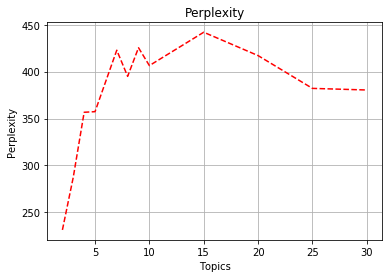

In [35]:
plt.title('Perplexity')
plt.xlabel('Topics')
plt.ylabel('Perplexity')
plt.grid(True) 
plt.show()

# Perplexiy seems to suggest 15 topics: 

### (5) Build an lda model with the suggested number of topics

In [36]:
# Build the lda model with the suggested number of topics

NUM_TOPICS = 15

lda_model_1 = models.LdaModel(corpus=bow_corpus
                             , num_topics=NUM_TOPICS
                             , id2word=dictionary
                             , passes = 20  # as we have a small corpus
                             , eta = 0.01 # topics are known to be word-sparse, the Dirichlet parameter of the word distributions is set small (e.g., 0.01), in which case learning is efficient.
                             , alpha = 0.1    #believed that each document is associated with few topics
                             )


/Users/alessia/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


### (6) Explore topics

In [37]:
# (iv) Explore Topics

print("LDA Model:")
 
for idx in range(NUM_TOPICS):
    # Print the first 5 most representative words for each topic
    print("Topic #%s:" % idx, lda_model_1.print_topic(idx, 5))
 
print("=" * 20)

# Really hard to understand the topics...


LDA Model:
Topic #0: 0.129*"look" + 0.108*"know" + 0.102*"give" + 0.095*"find" + 0.081*"try"
Topic #1: 0.238*"time" + 0.158*"see" + 0.115*"pretty" + 0.081*"show" + 0.069*"disappointed"
Topic #2: 0.318*"service" + 0.130*"restaurant" + 0.123*"definitely" + 0.119*"star" + 0.104*"two"
Topic #3: 0.467*"movie" + 0.097*"think" + 0.069*"see" + 0.060*"ve" + 0.052*"ll"
Topic #4: 0.564*"food" + 0.099*"experience" + 0.096*"enjoy" + 0.095*"recommend" + 0.093*"minute"
Topic #5: 0.270*"love" + 0.129*"take" + 0.120*"everything" + 0.120*"waste" + 0.107*"delicious"
Topic #6: 0.494*"place" + 0.090*"right" + 0.081*"price" + 0.068*"enough" + 0.062*"quality"
Topic #7: 0.206*"best" + 0.158*"way" + 0.154*"even" + 0.138*"thing" + 0.129*"nice"
Topic #8: 0.126*"wait" + 0.111*"story" + 0.107*"real" + 0.097*"actor" + 0.097*"excellent"
Topic #9: 0.281*"back" + 0.234*"character" + 0.100*"terrible" + 0.089*"server" + 0.074*"fantastic"
Topic #10: 0.809*"film" + 0.076*"salad" + 0.045*"watch" + 0.027*"work" + 0.018*"scr

The python package ```pyLDAvis``` is designed to help the interpretion of the topics in a topic model. The package extracts information from a fitted LDA topic model to inform an interactive web-based visualization (https://datascienceplus.com/topic-modeling-in-python-with-nltk-and-gensim/).

In [42]:
import pyLDAvis.gensim

lda_display = pyLDAvis.gensim.prepare(lda_model_1, bow_corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

/Users/alessia/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


Saliency: a measure of how much the term tells you about the topic.
Relevance: a weighted average of the probability of the word given the topic and the word given the topic normalized by the probability of the topic.
The size of the bubble measures the importance of the topics, relative to the data.